In [1]:
seed = 42

# Import libraries
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(seed)
from sklearn.utils import shuffle
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import mutual_info_classif
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
import h5py

from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression, SelectFromModel
sc = StandardScaler()

# vechhio codice

In [1]:
import pandas as pd

# Carica le tabelle
prima_tabella = pd.read_csv('/Users/alessiamenozzi/Desktop/features_blocchi_nuove.csv')  # La prima tabella con paziente, blocco e features
seconda_tabella = pd.read_csv('/Users/alessiamenozzi/Desktop/ThesisPlaques/data_rad_clin_DEF.csv')     # La seconda tabella con paziente, label ecc.


prima_tabella['paziente'] = prima_tabella['paziente'].apply(lambda x: f'patient_TC_{x}')


pazienti_prima_tabella = prima_tabella['paziente'].unique()


seconda_tabella_filtrata = seconda_tabella[seconda_tabella['IDs_new'].isin(pazienti_prima_tabella)]


mappa_sintomatico = dict(zip(seconda_tabella_filtrata['IDs_new'], seconda_tabella_filtrata['label']))


prima_tabella['Sintomatico'] = prima_tabella['paziente'].map(mappa_sintomatico)


prima_tabella.to_csv('/Users/alessiamenozzi/Desktop/features_blocchi_con_sintomatico.csv', index=False)


print(prima_tabella.head())


FileNotFoundError: [Errno 2] No such file or directory: '../CSV/Radiomica_3D.csv'

## clusterizzazione
Imputazione: Utilizziamo SimpleImputer con la strategia di imputazione della media (strategy='mean') per riempire i valori NaN.
PCA: Dopo aver gestito i NaN, riduciamo la dimensionalità delle features a 2 componenti per poterle visualizzare facilmente su un grafico bidimensionale. C'è SOLO UN VALORE DI NAN
K-Means: Applichiamo l'algoritmo di clustering K-Means sui dati trasformati dal PCA.
Visualizzazione: I risultati del clustering sono visualizzati con un grafico a dispersione (scatter plot).


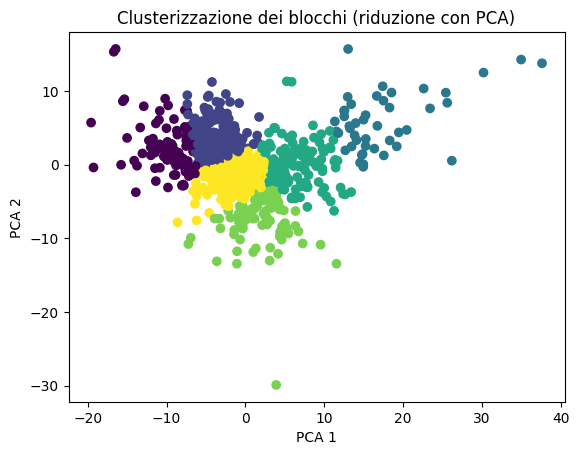

In [36]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


features = prima_tabella.drop(columns=['paziente', 'blocco', 'Sintomatico']).values

scaler = StandardScaler()
features = scaler.fit_transform(prima_tabella.drop(columns=['paziente', 'blocco', 'Sintomatico']))



imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)


pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_imputed)


kmeans = KMeans(n_clusters=6, random_state=42)
labels = kmeans.fit_predict(features_pca)


plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels, cmap='viridis')
plt.title('Clusterizzazione dei blocchi (riduzione con PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


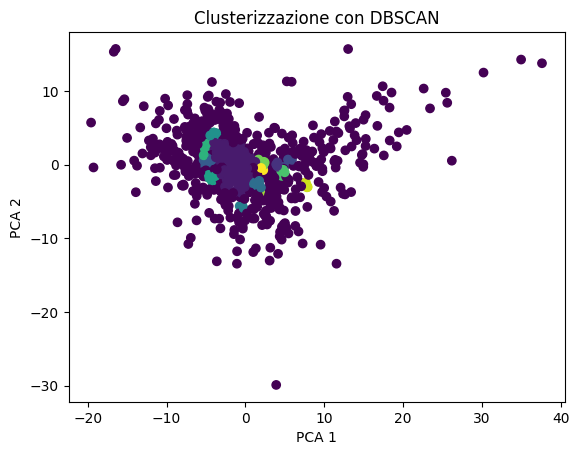

In [44]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


features = prima_tabella.drop(columns=['paziente', 'blocco', 'Sintomatico']).values

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features_scaled)


pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_imputed)

#  DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_dbscan = dbscan.fit_predict(features_pca)


plt.scatter(features_pca[:, 0], features_pca[:, 1], c=labels_dbscan, cmap='viridis')
plt.title('Clusterizzazione con DBSCAN')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


Silhouette Score per 2 clusters: 0.3954150597209888
Silhouette Score per 3 clusters: 0.34414495781518395
Silhouette Score per 4 clusters: 0.3252020977670702
Silhouette Score per 5 clusters: 0.27531505003250717
Silhouette Score per 6 clusters: 0.3167324785098368
Silhouette Score per 7 clusters: 0.3364892791230611
Silhouette Score per 8 clusters: 0.2908400846859936
Silhouette Score per 9 clusters: 0.2945750935062581
Silhouette Score per 10 clusters: 0.3006600134267146
Silhouette Score per 11 clusters: 0.30269683810265
Silhouette Score per 12 clusters: 0.29529682364354876
Silhouette Score per 13 clusters: 0.2943970700696902
Silhouette Score per 14 clusters: 0.2968351531377222
Silhouette Score per 15 clusters: 0.29709275256897305
Silhouette Score per 16 clusters: 0.2769083974187469
Silhouette Score per 17 clusters: 0.2794969663650803
Silhouette Score per 18 clusters: 0.27045765691034224
Silhouette Score per 19 clusters: 0.2711556350746963
Silhouette Score per 20 clusters: 0.273820542772340

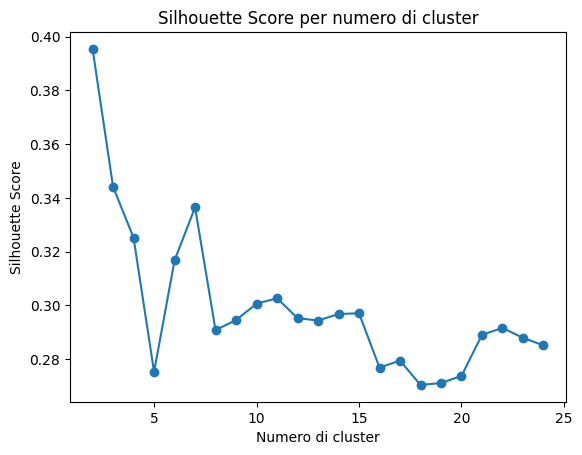

In [43]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Preprocessing
features = prima_tabella.drop(columns=['paziente', 'blocco', 'Sintomatico']).values

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features_scaled)

pca = PCA(n_components=4)
features_pca = pca.fit_transform(features_imputed)

silhouette_scores = []


for n_clusters in range(2, 25):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features_pca)
    score = silhouette_score(features_pca, labels)
    silhouette_scores.append(score)

# Visualizza il Silhouette Score per ogni numero di cluster
for i, score in enumerate(silhouette_scores, start=2):
    print(f"Silhouette Score per {i} clusters: {score}")

# Mostra i risultati graficamente
plt.plot(range(2, 25), silhouette_scores, marker='o')
plt.title('Silhouette Score per numero di cluster')
plt.xlabel('Numero di cluster')
plt.ylabel('Silhouette Score')
plt.show()


## silhoutte e gomito
indicano che i punti si classificano bene per 3 fold

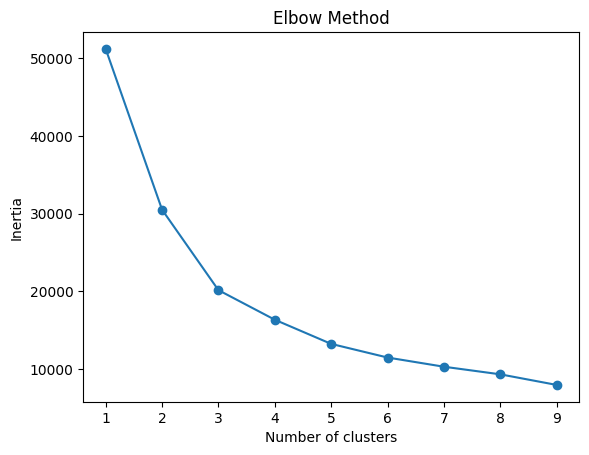

Silhouette Score: 0.33516872292578603


In [37]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(features_pca, labels)
print(f"Silhouette Score: {silhouette_avg}")


## t_sne
Cluster dominante: Il cluster viola potrebbe rappresentare un gruppo omogeneo o una distribuzione continua di dati con variazioni minime all'interno del gruppo.

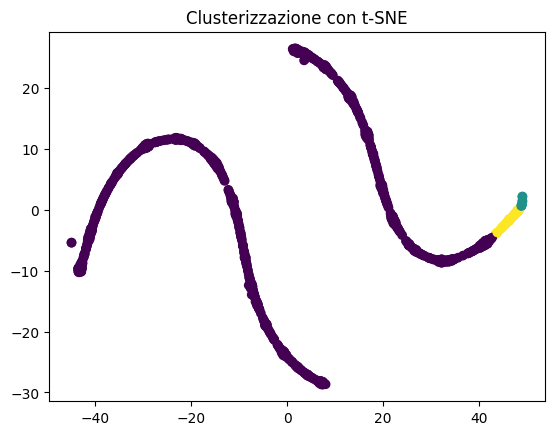

In [17]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_tsne = tsne.fit_transform(features_imputed)

plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels, cmap='viridis')
plt.title('Clusterizzazione con t-SNE')
plt.show()


In [19]:
explained_variance = pca.explained_variance_ratio_
print(f"Varianza spiegata dalle prime due componenti: {explained_variance[:2].sum()}")


Varianza spiegata dalle prime due componenti: 0.999999972390632


In [23]:
# Aggiungi i cluster alla tabella originale
prima_tabella['Cluster'] = labels

# Seleziona solo le colonne numeriche
numeric_columns = prima_tabella.select_dtypes(include=[np.number])

# Calcola la media delle features per ogni cluster
cluster_means = numeric_columns.groupby(prima_tabella['Cluster']).mean()

# Stampa i risultati
print(cluster_means)


              blocco  original_shape_Elongation  original_shape_Flatness  \
Cluster                                                                    
0        2159.734057                   0.616923                 0.328281   
1        2261.444444                   0.657855                 0.515786   
2        2124.771429                   0.723591                 0.550439   

         original_shape_LeastAxisLength  original_shape_MajorAxisLength  \
Cluster                                                                   
0                              7.067747                       20.166469   
1                             15.851076                       30.817565   
2                             17.310997                       31.724409   

         original_shape_Maximum2DDiameterColumn  \
Cluster                                           
0                                     18.975449   
1                                     32.306085   
2                                     3

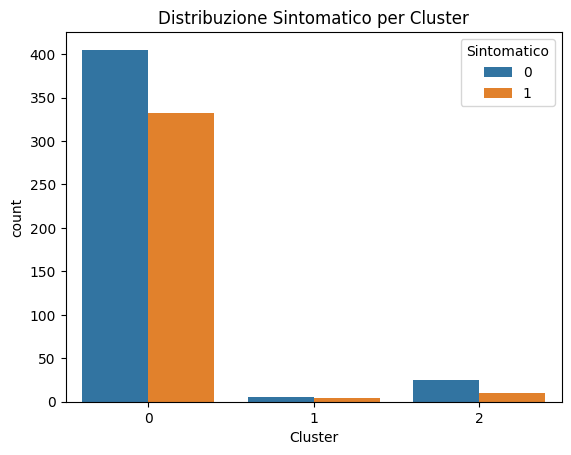

In [22]:
import seaborn as sns

# Conta il numero di pazienti sintomatici in ogni cluster
sns.countplot(x='Cluster', hue='Sintomatico', data=prima_tabella)
plt.title('Distribuzione Sintomatico per Cluster')
plt.show()


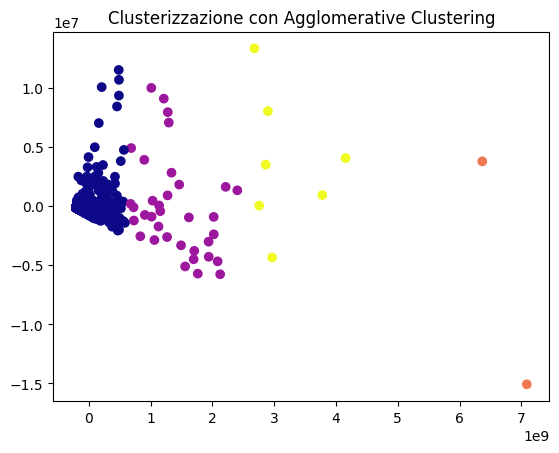

In [28]:
from sklearn.cluster import AgglomerativeClustering

agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_labels = agg_clustering.fit_predict(features_pca)

plt.scatter(features_pca[:, 0], features_pca[:, 1], c=agg_labels, cmap='plasma')
plt.title('Clusterizzazione con Agglomerative Clustering')
plt.show()


In [31]:
# Aggiungi le etichette del clustering al DataFrame
prima_tabella['Cluster'] = labels

# Conta i pazienti sintomatici e asintomatici in ciascun cluster
conteggi_cluster = prima_tabella.groupby(['Cluster', 'Sintomatico']).size().unstack(fill_value=0)
print(conteggi_cluster)


Sintomatico    0    1
Cluster              
0            405  332
1              5    4
2             25   10


# Nuovo codice

In [2]:

file_path = "./CSV/data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)

# Estrazione dei numeri dai nomi dei pazienti
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )

# Estrazione immagini
h5_file_path = 'images_by_patient_final.h5'

loaded_class_images = []

with h5py.File(h5_file_path, 'r') as h5_file:
    for key in h5_file.keys():
        images = np.array(h5_file[key])
        loaded_class_images.append(images)


print("Lunghezza della lista dei batch di immagini:", len(loaded_class_images))
print("Shape del batch di immagini del primo paziente:", loaded_class_images[0].shape)
print("Shape del batch di immagini del secondo paziente:", loaded_class_images[1].shape)



Labels: [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1]
Number of labels: 129
Patient Names:  [5, 12, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 126, 127, 128, 129, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 150, 153, 155, 158, 159, 161, 163, 166, 168, 169, 170, 171, 175, 176, 178, 182, 183, 188, 189, 190, 193, 197, 199, 200, 205]
Lunghezza della lista dei batch di immagini: 129
Shape del batch di immagini del primo paziente: (28, 64, 64)
S

## selezione slice piu grande per ogni paziente
in base alla quantità di pixel non neri

In [3]:

def estrai_immagine_massima_area(imagelist):
    """Restituisce l'immagine con il maggior numero di pixel non neri per un paziente."""
    max_non_black_pixels = 0
    max_image = None

    for image in imagelist:
        # Conta i pixel non neri (cioè diversi da 0)
        non_black_pixels = np.sum(image != 0)
        
        # Aggiorna se questa immagine ha più pixel non neri della precedente
        if non_black_pixels > max_non_black_pixels:
            max_non_black_pixels = non_black_pixels
            max_image = image

    return max_image

# Caricamento del file HDF5 con le immagini
h5_file_path = 'images_by_patient_final.h5'
loaded_class_images = []

with h5py.File(h5_file_path, 'r') as h5_file:
    for key in h5_file.keys():
        images = np.array(h5_file[key])
        loaded_class_images.append(images)

# Estrai l'immagine con l'area massima per ciascun paziente
immagini_massime_per_paziente = []
for imagelist in loaded_class_images:
    max_image = estrai_immagine_massima_area(imagelist)
    immagini_massime_per_paziente.append(max_image)

# Visualizza il risultato
print("Numero di immagini selezionate (una per paziente):", len(immagini_massime_per_paziente))
print("Shape dell'immagine selezionata per il primo paziente:", immagini_massime_per_paziente[0].shape)


Numero di immagini selezionate (una per paziente): 129
Shape dell'immagine selezionata per il primo paziente: (64, 64)


## prima trovo i contorni poi calcolo l'area dentro da massimizzare

In [4]:
import h5py
import cv2

def estrai_immagine_massima_area_con_contorno(imagelist):
    """Restituisce l'immagine con l'area più grande delimitata dal contorno di pixel non neri."""
    max_area = 0
    max_image = None

    for image in imagelist:
        # Crea una maschera per i pixel non neri (placca)
        mask = image > 0
        
        # Converti l'immagine in formato che OpenCV può elaborare
        mask_uint8 = mask.astype(np.uint8) * 255

        # Trova i contorni nell'immagine
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Considera solo il contorno più grande
        if contours:
            # Trova il contorno con la massima area
            largest_contour = max(contours, key=cv2.contourArea)

            # Calcola l'area del contorno
            area = cv2.contourArea(largest_contour)

            # Aggiorna se questa immagine ha un'area maggiore
            if area > max_area:
                max_area = area
                max_image = image

    return max_image, max_area

# Caricamento del file HDF5 con le immagini
h5_file_path = 'images_by_patient_final.h5'
loaded_class_images = []

with h5py.File(h5_file_path, 'r') as h5_file:
    for key in h5_file.keys():
        images = np.array(h5_file[key])
        loaded_class_images.append(images)

# Estrai l'immagine con l'area massima per ciascun paziente usando il nuovo criterio (contorno)
immagini_massime_per_paziente_contorno = []
aree_contorno = []

for imagelist in loaded_class_images:
    max_image, max_area = estrai_immagine_massima_area_con_contorno(imagelist)
    immagini_massime_per_paziente_contorno.append(max_image)
    aree_contorno.append(max_area)

# Calcola anche l'area utilizzando solo i pixel non neri (come facevi prima)
aree_non_nere = []
for imagelist in loaded_class_images:
    max_image = estrai_immagine_massima_area(imagelist)
    non_black_pixels = np.sum(max_image != 0)
    aree_non_nere.append(non_black_pixels)

# Visualizza i risultati
print("Numero di immagini selezionate (una per paziente):", len(immagini_massime_per_paziente_contorno))
print("Shape dell'immagine selezionata per il primo paziente (contorno):", immagini_massime_per_paziente_contorno[0].shape)

# Differenza tra area massimizzata col contorno e solo pixel non neri
differenze_tra_insiemi = np.array(aree_contorno) - np.array(aree_non_nere)

# Visualizza la differenza di aree tra il nuovo metodo e il precedente
for i, diff in enumerate(differenze_tra_insiemi):
    print(f"Diff. area paziente {i+1}: {diff}")


Numero di immagini selezionate (una per paziente): 129
Shape dell'immagine selezionata per il primo paziente (contorno): (64, 64)
Diff. area paziente 1: -12.5
Diff. area paziente 2: -3.5
Diff. area paziente 3: 63.0
Diff. area paziente 4: 93.0
Diff. area paziente 5: 44.0
Diff. area paziente 6: 44.0
Diff. area paziente 7: 166.0
Diff. area paziente 8: 46.0
Diff. area paziente 9: 86.5
Diff. area paziente 10: 60.0
Diff. area paziente 11: 38.5
Diff. area paziente 12: 94.5
Diff. area paziente 13: 185.5
Diff. area paziente 14: 78.5
Diff. area paziente 15: 112.5
Diff. area paziente 16: 228.0
Diff. area paziente 17: 67.0
Diff. area paziente 18: 204.0
Diff. area paziente 19: 115.5
Diff. area paziente 20: 176.0
Diff. area paziente 21: 92.0
Diff. area paziente 22: 85.5
Diff. area paziente 23: 178.5
Diff. area paziente 24: 25.5
Diff. area paziente 25: 47.0
Diff. area paziente 26: 29.5
Diff. area paziente 27: 2.0
Diff. area paziente 28: 155.5
Diff. area paziente 29: 145.0
Diff. area paziente 30: 43.0

IndexError: index 4 is out of bounds for axis 0 with size 4

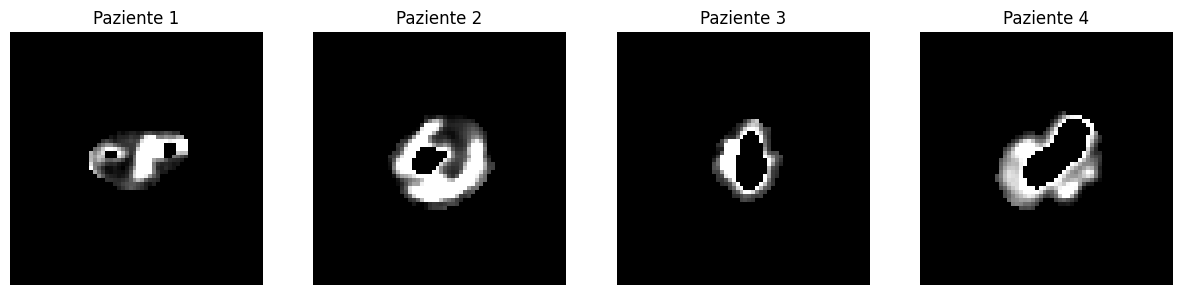

In [36]:
# Stampa delle immagini selezionate
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i, img in enumerate(immagini_massime_per_paziente_contorno):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Paziente {i+1}")

plt.show()


## divisione in blocchi per soglie di pixel

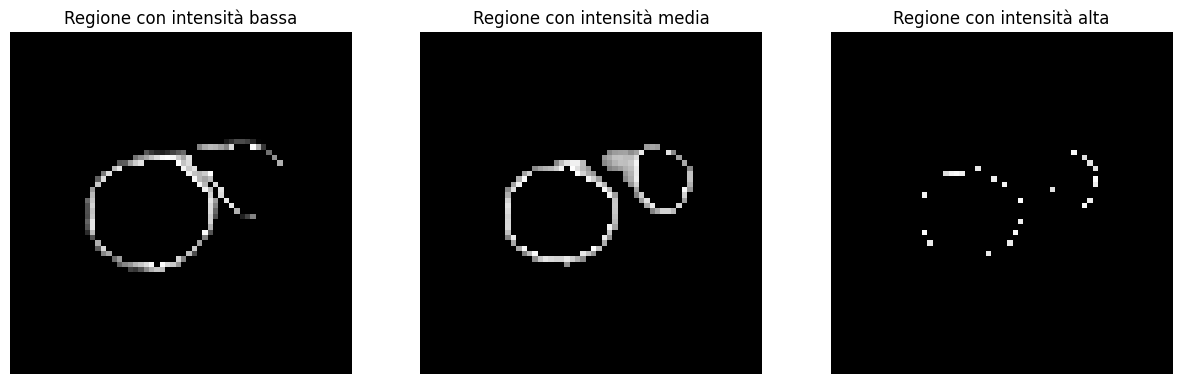

In [33]:
def segmenta_con_soglie(image, low_thresh, high_thresh):
    """Segmenta la placca in base a soglie di intensità."""
    # Crea maschere in base alle soglie definite
    mask_bassa = (image > 0) & (image <= low_thresh)  # Intensità bassa
    mask_media = (image > low_thresh) & (image <= high_thresh)  # Intensità media
    mask_alta = (image > high_thresh)  # Intensità alta

    # Applica le maschere per creare le regioni
    regione_bassa = image * mask_bassa
    regione_media = image * mask_media
    regione_alta = image * mask_alta

    return regione_bassa, regione_media, regione_alta

# Esempio di utilizzo con soglie
low_thresh = 80  # Soglia per intensità bassa
high_thresh = 160  # Soglia per intensità alta

# Applica la segmentazione alla prima immagine
regione_bassa, regione_media, regione_alta = segmenta_con_soglie(immagini_massime_per_paziente_contorno[17], low_thresh, high_thresh)

# Visualizza le diverse regioni
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(regione_bassa, cmap='gray')
axes[0].set_title("Regione con intensità bassa")
axes[0].axis('off')

axes[1].imshow(regione_media, cmap='gray')
axes[1].set_title("Regione con intensità media")
axes[1].axis('off')

axes[2].imshow(regione_alta, cmap='gray')
axes[2].set_title("Regione con intensità alta")
axes[2].axis('off')

plt.show()


## divisione per contorni

1


TypeError: 'Axes' object is not subscriptable

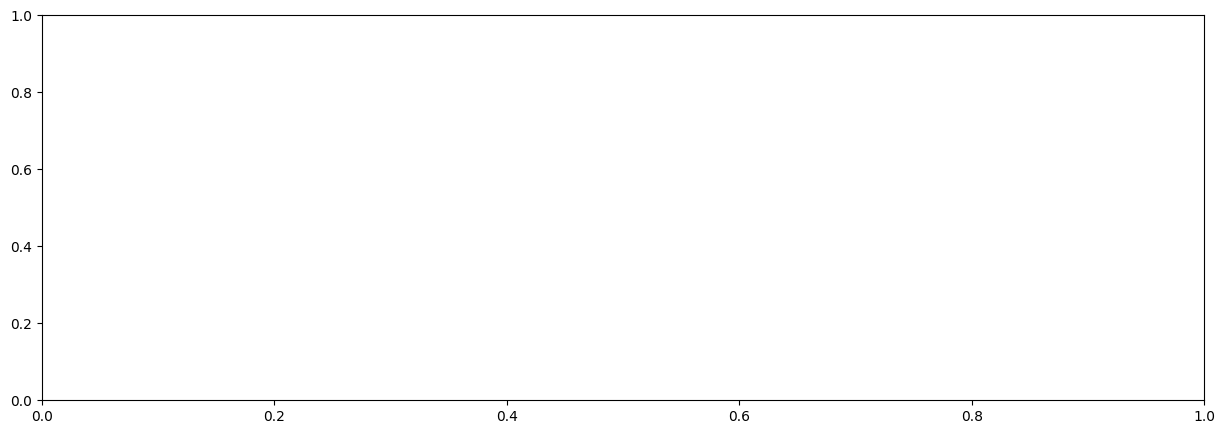

In [41]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def segmenta_per_contorni(image):
    """Segmenta l'immagine della placca trovando i contorni."""
    
    # Step 1: Crea una maschera binaria (pixel diversi da nero sono impostati a 255)
    _, thresh = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)

    # Step 2: Trova i contorni nell'immagine
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Step 3: Crea una lista delle aree segmentate
    segmented_regions = []
    for contour in contours:
        # Crea una maschera vuota
        mask = np.zeros_like(image)
        
        # Disegna il contorno sulla maschera
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        # Moltiplica la maschera per l'immagine originale per ottenere solo l'area segmentata
        region = mask * image
        
        # Aggiungi la regione segmentata alla lista
        segmented_regions.append(region)
    
    return segmented_regions

# Esempio di utilizzo con una delle immagini delle placche
image = immagini_massime_per_paziente_contorno[2]  # Sostituisci con l'immagine della placca

# Applica la segmentazione per contorni
segmented_regions = segmenta_per_contorni(image)
print(len(segmented_regions))
# Visualizza le regioni segmentate
fig, axes = plt.subplots(1, len(segmented_regions), figsize=(15, 5))
for i, region in enumerate(segmented_regions):
    axes[i].imshow(region, cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Regione {i+1}")

plt.show()


## estrai features radiomiche dai blocchi

In [28]:

from radiomics import featureextractor
import cv2


# Funzione per estrarre le features radiomiche da un'immagine (blocco)
def estrai_features_radiomiche(image_block):
    """Estrai le features radiomiche da un blocco di immagine."""
    extractor = featureextractor.RadiomicsFeatureExtractor()

    # Crea una maschera che include solo i pixel non neri (placca)
    mask = image_block > 0

    # Converti l'immagine e la maschera in file temporanei per l'uso con Pyradiomics
    cv2.imwrite('temp_block_image.png', image_block)
    cv2.imwrite('temp_block_mask.png', mask.astype(np.uint8) * 255)  # Converti maschera in formato binario

    # Estrai le features dall'immagine utilizzando la maschera e impostando la label a 255
    features = extractor.execute('temp_block_image.png', 'temp_block_mask.png', label=255)
    
    return features



# Crea una lista per raccogliere i risultati
dati_radiomici = []
i=0
# Loop attraverso ciascun paziente e segmenta le immagini in base all'intensità
for (image, name, label)  in zip(immagini_massime_per_paziente_contorno, loaded_patients, labels):
    # Segmenta l'immagine in base a intensità bassa, media e alta
    regione_bassa, regione_media, regione_alta = segmenta_con_soglie(image, low_thresh, high_thresh)
    print(i)
    i=i+1
    # Estrarre le features radiomiche per ogni regione
    for region_name, region in zip(['bassa', 'media', 'alta'], [regione_bassa, regione_media, regione_alta]):
        # Estrai le features radiomiche
        print(i)
        features = estrai_features_radiomiche(region)
        
        # Organizza i dati in una riga da inserire in tabella
        row = {
            "Paziente": name,
            "Regione": region_name,  # Nome della regione (bassa, media, alta)
            "Sintomatologia": label,  # Sintomatologia associata al paziente
        }
        
        # Aggiungi le features radiomiche alla riga
        for feature_name, feature_value in features.items():
            row[feature_name] = feature_value
        
        # Aggiungi la riga ai dati finali
        dati_radiomici.append(row)

# Crea una tabella (DataFrame) con i dati
df_radiomics = pd.DataFrame(dati_radiomici)

# Mostra i primi dati della tabella
df_radiomics.head()

# Rimuovi tutte le colonne che iniziano con "diagnostics"
df_radiomics= df_radiomics.loc[:, ~df_radiomics.columns.str.startswith('diagnostics')]

# Salva il nuovo DataFrame senza le colonne "diagnostics" in un file CSV
df_radiomics.to_csv("/Users/alessiamenozzi/Desktop/features_radiomiche_per_regioni.csv", index=False)



Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

0
1
1
1
1
2
2
2
2
3
3
3
3
4
4
4
4
5
5
5
5
6


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is 

6
6
6
7
7
7
7
8
8
8
8
9
9
9
9
10
10
10
10
11
11
11


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
S

11
12
12
12
12
13
13
13
13
14
14
14
14
15
15
15
15
16
16
16
16
17


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


17
17
17
18
18
18


ValueError: No labels found in this mask (i.e. nothing is segmented)!

## clusterizzo le features

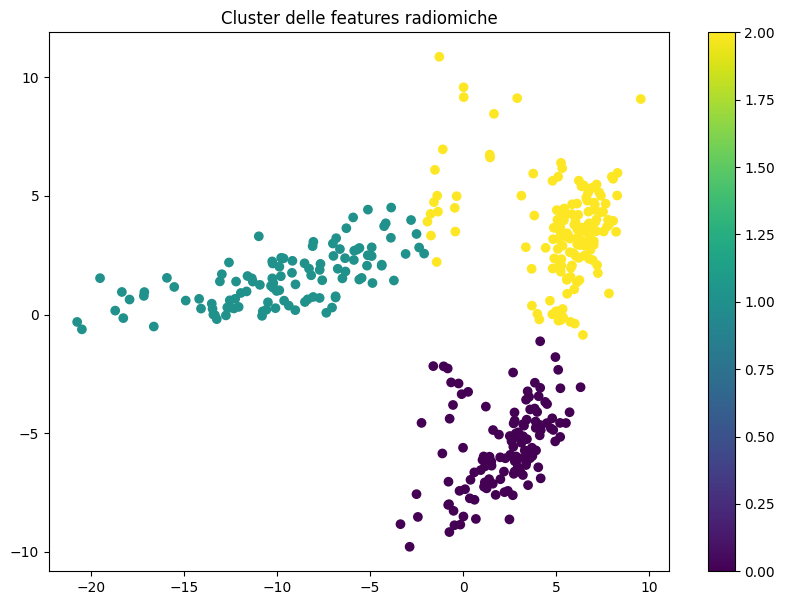

,Paziente,Regione,Sintomatologia,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,Cluster
0,5,bassa,0,17.0,84.0,407667.0,2.0195426841397595,35.25,2.223820993428526,100.0,...,0.09658420108066951,3.619983960238484,0.3142857142857143,14.421487603305783,2.2709577922077924,0.05604363397216404,5.162682865822609,0.06251464251006525,0.40753800797733974,0
1,5,media,0,109.8,187.2,1203007.0,1.9521319853865435,47.5,1.7699255416745496,198.0,...,0.3319627192982456,3.0418145155018115,0.6909090909090909,0.4577562326869806,2.9361961451247165,0.08919866008939173,4.253310536335746,0.16318718471611035,0.46078098892258174,2
2,5,alta,0,223.0,255.0,4929656.0,0.7916372432323078,0.0,7.325226833514463,255.0,...,0.42194701265614726,2.524397470347697,0.20253164556962025,152.30859375,1.2212312030075188,0.08511686252780151,1.1882053401691737,0.054176550700760745,0.32379781055030127,1
3,12,bassa,1,26.800000000000004,90.0,889520.0,1.8445399383912462,31.5,2.7466897879079633,100.0,...,0.08823413919989376,4.261902467700733,0.27053140096618356,22.56855867346939,2.273714301651048,0.030468695378055924,5.7310994134578515,0.05079381727724188,0.2352941509904277,0
4,12,media,1,108.10000000000001,178.6,1816820.0,1.9530702598291234,47.25,1.903544601727144,197.0,...,0.3642843670389967,2.901415684392078,0.7159090909090909,0.9377676996724615,11.573989898989899,0.038400279274758364,6.305350427110002,0.2247453673811983,0.20273046892835947,2


In [29]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Filtriamo solo le colonne con le features numeriche per il clustering
features_columns = [col for col in df_radiomics.columns if col not in ["Paziente", "Regione", "Sintomatologia"]]
X = df_radiomics[features_columns]

# Step 1: Normalizzazione delle features (opzionale ma raccomandato)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Definisci il numero di cluster (es. 3 per iniziare: intensità bassa, media, alta)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Step 3: Applica K-means
df_radiomics['Cluster'] = kmeans.fit_predict(X_scaled)

# Step 4: Aggiungi i cluster al DataFrame originale
df_radiomics['Cluster'] = kmeans.labels_

# Step 5: Visualizzazione dei cluster (usiamo PCA per ridurre a 2D)
from sklearn.decomposition import PCA

# Riduzione delle dimensioni a 2D per visualizzazione
pca = PCA(2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_radiomics['Cluster'], cmap='viridis')
plt.colorbar()
plt.title('Cluster delle features radiomiche')
plt.show()

# Step 6: Visualizza i primi dati con i cluster assegnati
df_radiomics.head()


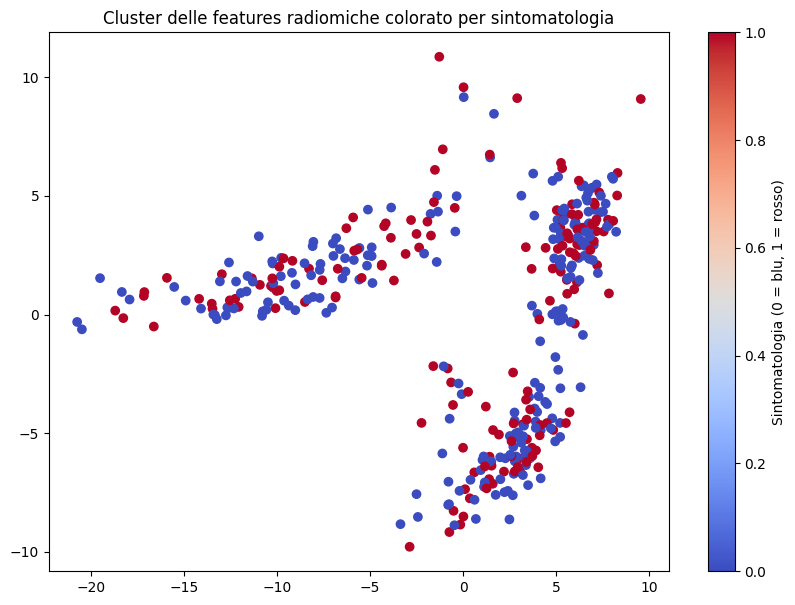

In [30]:
# Coloriamo i punti del grafico in base alla sintomatologia
plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_radiomics['Sintomatologia'], cmap='coolwarm')
plt.colorbar(label='Sintomatologia (0 = blu, 1 = rosso)')
plt.title('Cluster delle features radiomiche colorato per sintomatologia')
plt.show()


## analizziamo la correlazione tra sintomatologia e features
non ci sono features con una forte correlazione con la sintomatologia (max 0.08 0 0.09)

In [34]:
# Analisi di correlazione tra le features radiomiche e la sintomatologia
correlation = df_radiomics[features_columns + ['Sintomatologia']].corr()

# Visualizziamo la correlazione delle features con la sintomatologia
correlation_with_sintomatologia = correlation['Sintomatologia'].sort_values(ascending=False)

# Crea una tabella con la correlazione e i valori assoluti per ordinamento migliore
correlation_table = pd.DataFrame({
    'Feature': correlation_with_sintomatologia.index,
    'Correlation with Sintomatologia': correlation_with_sintomatologia.values,
    'Absolute Correlation': correlation_with_sintomatologia.abs().values
})

# Ordina in base alla correlazione assoluta
correlation_table = correlation_table.sort_values(by='Absolute Correlation', ascending=False)

# Mostra la tabella ordinata
print(correlation_table)

# Se vuoi salvare la tabella in un file CSV
#correlation_table.to_csv("/Users/alessiamenozzi/Desktop/correlation_with_sintomatologia.csv", index=False)


                                            Feature  \
0                                    Sintomatologia   
94                               original_glcm_Imc1   
93                        original_glrlm_RunEntropy   
1   original_gldm_DependenceNonUniformityNormalized   
92                  original_glcm_ClusterProminence   
..                                              ...   
41                       original_firstorder_Median   
40                         original_firstorder_Mean   
37     original_glszm_SmallAreaLowGrayLevelEmphasis   
39         original_glszm_HighGrayLevelZoneEmphasis   
38                      original_firstorder_Maximum   

    Correlation with Sintomatologia  Absolute Correlation  
0                          1.000000              1.000000  
94                        -0.090224              0.090224  
93                        -0.082629              0.082629  
1                          0.080817              0.080817  
92                        -0.065269    